# A machine learning approach to improve RFID gate operation

## Basic configuration

In [119]:
# Bibliotecas necesarias
import numpy as np
import os

# Configuramos matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Semilla fija para reproducibilidad
np.random.seed(1)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Dataset import

In [121]:
import pandas

data = pandas.read_csv("batches.txt") 
data["ratioread"] = data.ntagsread/data.ntags
data.shape
data.head(10)


,tags1,prx1,prxcol1,tags2,prx2,prxcol2,tags3,prx3,prxcol3,p1,p2,p3,read,ntags,ntagsread,t,L,deltax,deltay,ratioread
0,35,57.370666,47.136963,33,85.475974,83.518197,25,52.815746,74.308925,0,1,0,1,121,121,0.38017,1.2,0.045695,0.120441,1.000000
1,17,342.689869,175.303766,41,25.858434,20.239015,16,26.952245,0.000000,0,1,0,0,823,336,3.42749,1.2,-0.537777,0.217907,0.408262
2,16,12.713636,9.887868,28,883.634976,354.403516,6,56.289143,31.524838,0,0,1,0,686,422,3.04516,1.2,0.971399,-0.231429,0.615160
3,34,760.119673,389.551105,12,9.020537,8.547781,6,9.946548,10.464317,0,1,0,0,521,113,2.46165,1.2,-1.015182,-0.137959,0.216891
4,64,460.929094,424.343659,2,2.251396,0.000000,96,22.899492,21.818472,0,0,1,1,280,280,0.87973,1.2,-1.379577,0.017249,1.000000
5,36,32.326179,27.017891,31,335.763463,182.385486,24,33.853371,44.310590,0,0,1,0,585,543,2.57785,1.2,0.523825,0.116696,0.928205
6,47,41.810212,29.840883,10,278.466763,137.373995,193,184.512026,184.230827,0,1,0,1,958,958,3.19030,1.2,0.396206,0.144744,1.000000
7,55,234.078506,166.124869,36,31.681251,23.486592,74,32.120123,26.429168,0,0,1,1,305,305,0.94775,1.2,-0.474664,-0.183170,1.000000
8,59,310.608958,225.323499,33,27.139398,23.946196,25,19.803142,10.956988,0,1,0,0,346,235,1.35816,1.2,-0.587279,-0.047222,0.679191
9,60,520.042280,328.811294,8,12.026846,0.000000,58,370.883397,319.738150,1,0,0,1,211,211,0.65407,1.2,-1.014063,0.067311,1.000000


In [156]:
X=np.array(data[['tags1','prx1','prxcol1','tags2','prx2','prxcol2','tags3','prx3','prxcol3','p1','p2','p3']].values) # R=3
#X=np.array(data[['tags1','prx1','prxcol1','tags2','prx2','prxcol2','p1','p2','p3']].values) # R=2
# X=np.array(data[['tags1','prx1','prxcol1','p1','p2','p3']].values)  # R=1
t=np.array(data.read.values)
n=np.array(data.read.values)
tI=np.array(data.t.values)
print(X.shape,t.shape,n.shape,tI.shape)

(119978, 12) (119978,) (119978,) (119978,)


## Network layout definition

In [158]:
# Entrenamos un autoencoder construido en keras
import keras

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

from sklearn.model_selection import train_test_split
X_train, X_test, t_train, t_test, tI_train, tI_test =  train_test_split(X, t, tI, test_size=0.2)
print(X_test.shape, tI_test.shape)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

standard_transformer = Pipeline(steps=[
        ('standard', StandardScaler())])

minmax_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler())])

preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', standard_transformer , []),
            ('mm', minmax_transformer , slice(1,9))
        ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#print(X_train[:10],X_test[:10])
print(t_train[:10])

(23996, 12) (23996,)
[1 0 1 1 1 0 1 0 1 1]


## ANN training

### Model load

In [124]:
model = keras.models.Sequential([
    keras.layers.Dense(20, activation="tanh", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary

try: 
    model = keras.models.load_model("modelrfidR3_plm.h5") # Load trained model
except:
    pass


### Model training, run to retrain

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("modelrfidR3.h5", save_best_only=True)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, t_train, epochs=50000, 
                    validation_data=(X_test, t_test), 
                    callbacks=[checkpoint_cb, early_stopping_cb])

print(history.params)

import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Statistics and graphics

In [83]:
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [125]:
print(f'The score (accurary) in the training set is {model.evaluate(X_train,t_train)[1]*100:.02f}%')
print(f'The score (accuracy) in the test set is {model.evaluate(X_test,t_test)[1]*100:.02f}%\n')

from sklearn.metrics import confusion_matrix

y_test = model.predict_classes(X_test)
conf_mx = confusion_matrix(list(map(int,t_test)), y_test)
print(conf_mx)
print(f'Recall: {conf_mx[1,1]/(conf_mx[1,1]+conf_mx[0,1])*100:0.2f}%')
print(f'Fall-out: {conf_mx[1,0]/(conf_mx[1,0]+conf_mx[0,0])*100:0.2f}%')

95982/95982 [==============================] - 2s 23us/step
The score (accurary) in the training set is 95.04%
23996/23996 [==============================] - 1s 21us/step
The score (accuracy) in the test set is 95.03%

[[11567   609]
 [  584 11236]]
Recall: 94.86%
Fall-out: 4.81%


In [220]:
from sklearn.metrics import confusion_matrix

Xt = X_test;
tt = t_test;

Xta = X_test[X_test[:,9]==1]
tta = t_test[X_test[:,9]==1]

Xtb = X_test[X_test[:,10]==1]
ttb = t_test[X_test[:,10]==1]

Xtg = X_test[X_test[:,11]==1]
ttg = t_test[X_test[:,11]==1]

print(Xta.shape, Xtb.shape, Xtg.shape)

print(f'All-policies accuracy is {model.evaluate(Xt,tt)[1]*100:.02f}%\n')
yt = model.predict_classes(Xt)
conf_mx = confusion_matrix(list(map(int,tt)), yt)
print(conf_mx)
print(f'Recall: {conf_mx[1,1]/(conf_mx[1,1]+conf_mx[0,1])*100:0.2f}%')
print(f'Fall-out: {conf_mx[1,0]/(conf_mx[1,0]+conf_mx[0,0])*100:0.2f}%')
precisionall = conf_mx[1,1]/(conf_mx[1,1]+conf_mx[1,0])
print(f'Precision: {precisionall*100:0.2f}%\n')

print(f'Alpha-policy accuracy is {model.evaluate(Xta,tta)[1]*100:.02f}%\n')
yta = model.predict_classes(Xta)
conf_mx = confusion_matrix(list(map(int,tta)), yta)
print(conf_mx)
print(f'Recall: {conf_mx[1,1]/(conf_mx[1,1]+conf_mx[0,1])*100:0.2f}%')
print(f'Fall-out: {conf_mx[1,0]/(conf_mx[1,0]+conf_mx[0,0])*100:0.2f}%')
precisiona = conf_mx[1,1]/(conf_mx[1,1]+conf_mx[1,0])
print(f'Precision: {precisiona*100:0.2f}%\n')

print(f'Beta-policy accuracy is {model.evaluate(Xtb,ttb)[1]*100:.02f}%\n')
ytb = model.predict_classes(Xtb)
conf_mx = confusion_matrix(list(map(int,ttb)), ytb)
print(conf_mx)
print(f'Recall: {conf_mx[1,1]/(conf_mx[1,1]+conf_mx[0,1])*100:0.2f}%')
print(f'Fall-out: {conf_mx[1,0]/(conf_mx[1,0]+conf_mx[0,0])*100:0.2f}%')
precisionb = conf_mx[1,1]/(conf_mx[1,1]+conf_mx[1,0])
print(f'Precision: {precisionb*100:0.2f}%\n')

print(f'Gamma-policy accuracy is {model.evaluate(Xtg,ttg)[1]*100:.02f}%\n')
ytg = model.predict_classes(Xtg)
conf_mx = confusion_matrix(list(map(int,ttg)), ytg)
print(conf_mx)
print(f'Recall: {conf_mx[1,1]/(conf_mx[1,1]+conf_mx[0,1])*100:0.2f}%')
print(f'Fall-out: {conf_mx[1,0]/(conf_mx[1,0]+conf_mx[0,0])*100:0.2f}%')
precisiong = conf_mx[1,1]/(conf_mx[1,1]+conf_mx[1,0])
print(f'Precision: {precisiong*100:0.2f}%\n')

(7930, 12) (8194, 12) (7872, 12)
23996/23996 [==============================] - 1s 28us/step
All-policies accuracy is 94.86%

[[11553   613]
 [  621 11209]]
Recall: 94.81%
Fall-out: 5.10%
Precision: 94.75%

7930/7930 [==============================] - 0s 22us/step
Alpha-policy accuracy is 94.59%

[[4429  195]
 [ 234 3072]]
Recall: 94.03%
Fall-out: 5.02%
Precision: 92.92%

8194/8194 [==============================] - 0s 22us/step
Beta-policy accuracy is 94.73%

[[4569  171]
 [ 261 3193]]
Recall: 94.92%
Fall-out: 5.40%
Precision: 92.44%

7872/7872 [==============================] - 0s 22us/step
Gamma-policy accuracy is 95.26%

[[2555  247]
 [ 126 4944]]
Recall: 95.24%
Fall-out: 4.70%
Precision: 97.51%



# Simulator

1. An ANN is created to predict the interrogation time expended given the batch signature
2. The best policy is compared againts 3 static policies (alpha, beta and gamma)

## ANN time prediction

In [216]:
modeltime = keras.models.Sequential([
    keras.layers.Dense(20, activation="tanh", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1, activation="linear")
])

modeltime.summary

try: 
    modeltime = keras.models.load_model("modelrfidR3_time_plm.h5") # Load trained model
    print(f'The score (ratio rmse/meanIT) in the test set is {np.sqrt(modeltime.evaluate(X_test,tI_test))/np.mean(tI_test)*100:.2f}%\n')
except:
    pass

23996/23996 [==============================] - 0s 20us/step
The score (ratio rmse/meanIT) in the test set is 27.08%



2.0836891752792104

Train on 95982 samples, validate on 23996 samples
Epoch 1/50
95982/95982 [==============================] - 5s 56us/step - loss: 0.2819 - val_loss: 0.3217
Epoch 2/50
95982/95982 [==============================] - 5s 55us/step - loss: 0.2815 - val_loss: 0.3183
Epoch 3/50
95982/95982 [==============================] - 5s 55us/step - loss: 0.2815 - val_loss: 0.3187
Epoch 4/50
95982/95982 [==============================] - 5s 54us/step - loss: 0.2817 - val_loss: 0.3194
Epoch 5/50
95982/95982 [==============================] - 5s 54us/step - loss: 0.2812 - val_loss: 0.3279
Epoch 6/50
95982/95982 [==============================] - 5s 54us/step - loss: 0.2816 - val_loss: 0.3188
Epoch 7/50
95982/95982 [==============================] - 5s 54us/step - loss: 0.2813 - val_loss: 0.3189
Epoch 8/50
95982/95982 [==============================] - 5s 54us/step - loss: 0.2815 - val_loss: 0.3221
Epoch 9/50
95982/95982 [==============================] - 5s 54us/step - loss: 0.2811 - val_loss: 0.3208
Epoch

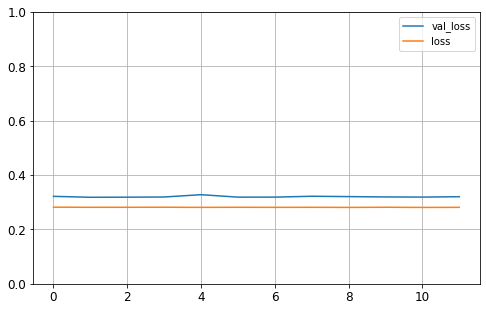

In [212]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("modelrfidR3_time_plm.h5", save_best_only=True)

modeltime.compile(loss="mse", optimizer="adam")
historytime = modeltime.fit(X_train, tI_train, epochs=50, 
                    validation_data=(X_test, tI_test), 
                    callbacks=[checkpoint_cb, early_stopping_cb])

print(historytime.params)

import pandas as pd

pd.DataFrame(historytime.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## TIME SIMULATOR

In [218]:
time = 0
referencetime = 0.1
timea = 0
timeb = 0
timeg = 0
countbest = 0
counta = 0
countb = 0
countg = 0

#for i in range(X_test.shape[0]):
for i in range(1000):
    
    x = np.array([X_test[i,:]])
    time += referencetime
    timea += referencetime
    timeb += referencetime
    timeg += referencetime
    
    # Alpha-policy
    x[:,9] = 1
    x[:,10] = 0
    x[:,11] = 0
    ya = model.predict(x)[0,0]
    
     # Beta-policy
    x[:,9] = 0
    x[:,10] = 1 
    x[:,11] = 0
    yb = model.predict(x)[0,0]
    
     # Gamma-policy
    x[:,9] = 0
    x[:,10] = 0
    x[:,11] = 1 
    yg = model.predict(x)[0,0] 
    
    if ya>yb and ya>yg:
        policy = 'alpha'
        precision = precisiona 
        y = ya
    elif yb>ya and yb>yg:
        policy = 'beta'
        precision = precisionb
        y = yb
    else:
        policy = 'gamma'
        precision = precisiong
        y = yg
    
    y = float(y)
    
    # Best policy
    # print(f'Policy: {policy}, PIB: {y*100:0.2f}%, precision: {y*100:0.2f}%')
    time += modeltime.predict(x)[0,0]
    if np.random.random()<y and np.random.random()<precision: 
        # Correct inventory
        countbest += 1
    else:
        # Inventory fault
        time += 10 + 20*np.random.random() 
        
    # Static policy alfa
    x[:,9] = 1
    x[:,10] = 0 
    x[:,11] = 0 
    y = model.predict(x)[0,0]
    timea += modeltime.predict(x)[0,0]
    if np.random.random()<y and np.random.random()<precisiona: 
            # Correct inventory
            counta += 1
    else:
        # Inventory fault
        timea += 10 + 20*np.random.random() 
        
    # Static policy beta
    x[:,9] = 0
    x[:,10] = 1 
    x[:,11] = 0
    y = model.predict(x)[0,0]
    timeb += modeltime.predict(x)[0,0]
    if np.random.random()<y and np.random.random()<precisionb: 
            # Correct inventory
            countb += 1
    else:
        # Inventory fault
        timeb += 10 + 20*np.random.random() 
        
    # Static policy gamma
    x[:,9] = 0
    x[:,10] = 0
    x[:,11] = 1
    y = model.predict(x)[0,0]
    timeg += modeltime.predict(x)[0,0]
    if np.random.random()<y and np.random.random()<precisiong: 
            # Correct inventory
            countg += 1
    else:
        # Inventory fault
        timeg += 10 + 20*np.random.random() 
        
    #print(f'{i}, {time}, {timea}, {timeb}, {timeg}')
    print(f'{i}, {countbest}, {counta}, {countb}, {countg}')
    
    

0, 0, 0, 0, 0
1, 1, 1, 0, 1
2, 2, 1, 1, 1
3, 3, 1, 2, 1
4, 4, 2, 3, 2
5, 5, 2, 4, 3
6, 6, 2, 5, 3
7, 7, 2, 5, 3
8, 8, 2, 6, 4
9, 9, 2, 7, 5
10, 10, 3, 7, 6
11, 11, 3, 8, 7
12, 12, 4, 8, 8
13, 12, 4, 8, 8
14, 13, 5, 8, 9
15, 14, 5, 9, 9
16, 14, 5, 9, 9
17, 15, 6, 9, 9
18, 16, 6, 9, 10
19, 17, 6, 9, 11
20, 18, 7, 9, 12
21, 18, 7, 9, 12
22, 19, 8, 9, 13
23, 20, 9, 9, 14
24, 21, 10, 9, 15
25, 22, 11, 9, 16
26, 23, 12, 9, 17
27, 23, 12, 10, 17
28, 24, 13, 11, 18
29, 25, 14, 12, 19
30, 26, 14, 13, 19
31, 26, 14, 14, 19
32, 26, 14, 14, 19
33, 27, 15, 14, 20
34, 28, 15, 14, 21
35, 29, 15, 15, 22
36, 30, 15, 15, 22
37, 31, 15, 16, 22
38, 31, 15, 16, 22
39, 31, 15, 17, 22
40, 32, 16, 17, 23
41, 33, 17, 17, 24
42, 34, 18, 17, 24
43, 35, 19, 17, 25
44, 36, 19, 18, 25
45, 37, 19, 19, 25
46, 38, 19, 19, 26
47, 38, 19, 19, 26
48, 39, 19, 19, 26
49, 40, 20, 19, 27
50, 41, 21, 20, 28
51, 41, 22, 21, 29
52, 42, 23, 21, 30
53, 43, 23, 22, 30
54, 44, 24, 23, 30
55, 45, 25, 23, 31
56, 46, 26, 24, 32
57, 47

389, 318, 169, 161, 247
390, 319, 170, 162, 248
391, 320, 170, 163, 248
392, 321, 171, 164, 249
393, 322, 172, 165, 250
394, 322, 172, 166, 251
395, 323, 172, 167, 252
396, 324, 173, 167, 252
397, 324, 173, 168, 252
398, 325, 173, 168, 253
399, 325, 174, 169, 254
400, 326, 175, 169, 255
401, 327, 176, 169, 256
402, 328, 177, 169, 257
403, 329, 178, 169, 258
404, 330, 179, 169, 259
405, 331, 180, 169, 260
406, 332, 180, 169, 261
407, 332, 180, 169, 261
408, 333, 181, 170, 262
409, 334, 182, 170, 263
410, 335, 182, 171, 263
411, 336, 183, 171, 264
412, 337, 184, 172, 264
413, 338, 185, 172, 265
414, 339, 185, 172, 266
415, 340, 185, 173, 267
416, 341, 186, 173, 268
417, 342, 187, 173, 269
418, 343, 188, 173, 270
419, 344, 188, 174, 271
420, 345, 189, 174, 272
421, 346, 190, 175, 273
422, 347, 190, 176, 273
423, 347, 190, 176, 273
424, 348, 191, 176, 274
425, 349, 192, 176, 275
426, 350, 193, 177, 276
427, 350, 193, 177, 276
428, 351, 193, 178, 277
429, 352, 193, 179, 277
430, 353, 193, 1

735, 585, 330, 308, 476
736, 586, 331, 308, 477
737, 586, 331, 308, 477
738, 587, 331, 309, 477
739, 587, 331, 309, 477
740, 588, 332, 310, 478
741, 589, 332, 311, 479
742, 589, 332, 312, 479
743, 590, 333, 312, 480
744, 591, 334, 312, 481
745, 592, 335, 313, 481
746, 593, 336, 314, 481
747, 594, 336, 314, 481
748, 595, 336, 315, 481
749, 596, 336, 315, 481
750, 597, 336, 315, 481
751, 598, 337, 315, 481
752, 599, 338, 316, 482
753, 600, 338, 317, 482
754, 601, 339, 317, 483
755, 602, 339, 317, 484
756, 603, 339, 317, 484
757, 603, 339, 317, 484
758, 604, 340, 318, 484
759, 605, 341, 319, 485
760, 606, 342, 319, 486
761, 607, 342, 319, 486
762, 608, 343, 319, 487
763, 609, 344, 319, 488
764, 609, 344, 319, 488
765, 610, 344, 320, 489
766, 611, 344, 321, 490
767, 612, 345, 322, 491
768, 613, 345, 323, 492
769, 614, 345, 323, 493
770, 614, 345, 323, 493
771, 615, 346, 324, 494
772, 615, 346, 324, 494
773, 616, 347, 325, 495
774, 617, 347, 326, 496
775, 618, 347, 327, 497
776, 619, 348, 3